<font size="5">
 <div class="alert alert-block alert-info"> <b>Week 7: Deep Neural Networks (DNNs)<b>
     </div>
</font>

      
    
  <font size="4"> MCD - Análise de Séries Temporais e Previsão </font>
  
  
  <font size="3"> **Filipe R. Ramos** </font>
      
   
  <font size="3"> *frjrs@iscte-iul.pt* </font>  
   
    
  <font size="3">ISCTE-IUL </font>

<font size="5">
    <div class="alert alert-warning" role="alert"> -- Deep Neural Networks -- </div> </font>

## **Agenda**

1. Deep Neural Networks (DNNs): Introduction

2. Recurrent Neural Networks (RNNs)

3. **Long Short-Term Memory** (LSTM)
---------------------


## **References**
- [Chollet, F. (2017)](https://sourestdeeds.github.io/pdf/Deep%20Learning%20with%20Python.pdf)

- [Haykin, S. (2009)](https://lps.ufrj.br/~caloba/Livros/Haykin2009.pdf)


- [Introduction to Machine Learning with Python  book](https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/)


# **Import libraries**

In [7]:
### bibliotecas


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf

# **Import Data**

There are 2955 observations in the training data
There are 2955 observations in the test data


<Axes: xlabel='Date'>

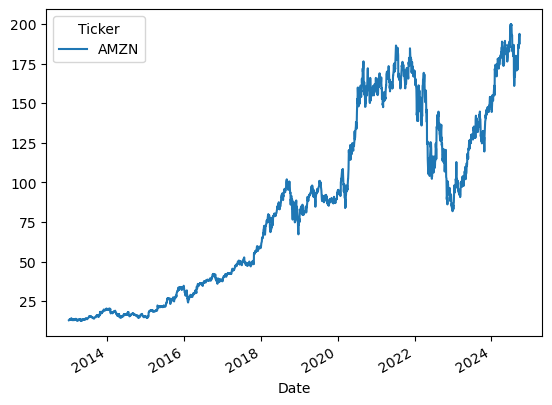

In [8]:
### importar dados do yahoo finance


AMZN = yf.download('AMZN',
                      start='2013-01-01',
                      end='2024-09-30',
                      progress=False)

# AMZN = yf.download('AMZN') for all
all_data = AMZN[['Open', 'High', 'Low', 'Close', 'Volume']].round(2)
all_data.head(10)
print("There are "+ str(all_data[:'2023'].shape[0]) + " observations in the training data")
print("There are "+ str(all_data['2024':].shape[0]) + " observations in the test data")
all_data['Close'].plot()




# **Data Preparation**

In [9]:
### função que faz a divisão em treino-teste, normaliza os dados
### transforma a séries temporal (e os lags) numa dataframe


def ts_train_test_normalize(all_data,time_steps,for_periods):
    '''
    input:
      data: dataframe with dates and price data
    output:
      X_train, y_train: data from 2013/1/1-2023/12/31
      X_test:  data from 2024 -
      sc:      insantiated MinMaxScaler object fit to the training data
    '''
    # create training and test set
    ts_train = all_data.loc[:'2023', ["Close"]].values
    ts_test = all_data.loc['2024':, ["Close"]].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # scale the data
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1):
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((all_data["Close"][:'2023'], all_data["Close"]['2024':]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    # Preparing X_test
    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])

    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, sc

X_train, y_train, X_test, sc = ts_train_test_normalize(all_data,5,2)
X_train.shape[0],X_train.shape[1]

(2762, 5)

In [10]:
### função para representar graficamente os valores preditos vs teste


def actual_pred_plot(preds):
    #Plot the actual vs. prediction
    actual_pred = pd.DataFrame(columns = ['Close', 'prediction'])
    actual_pred['Close'] = all_data.loc['2024':,'Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    from keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Close']),np.array(actual_pred['prediction']))

    return (m.result().numpy(), actual_pred.plot() )

In [11]:
# Convert the 3-D shape of X_train to a data frame so we can see:
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0],X_train.shape[1])))
y_train_see = pd.DataFrame(y_train)
pd.concat([X_train_see,y_train_see],axis=1)

# Convert the 3-D shape of X_test to a data frame so we can see:
X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0],X_test.shape[1])))
pd.DataFrame(X_test_see)

print("There are " + str(X_train.shape[0]) + " samples in the training data")
print("There are " + str(X_test.shape[0]) + " samples in the test data")

There are 2762 samples in the training data
There are 185 samples in the test data


# **LSTM Model - Forecasting**

c:\Users\diogo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step


(18.21176, <Axes: xlabel='Date'>)

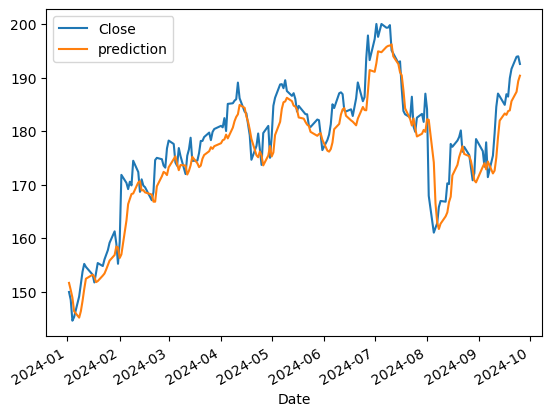

In [12]:
## função para LSTM


def LSTM_model(X_train, y_train, X_test, sc):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from keras.optimizers import SGD, Adam

    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, activation='tanh')) #Como é a última camada LSTM, a rede não precisa mais de uma sequência de saídas, apenas a saída final.
    my_LSTM_model.add(Dense(units=1))

    # Compiling
    my_LSTM_model.compile(optimizer=Adam(learning_rate=0.01),loss='mean_squared_error')
    # Fitting to the training set
    my_LSTM_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=0)

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

X_train, y_train, X_test, sc = ts_train_test_normalize(all_data,5,2)
my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)
LSTM_prediction[1:10]
actual_pred_plot(LSTM_prediction)


#Pedir, caso queiram, o vetor das previsões

#print(LSTM_prediction)



In [13]:
### Calcular métricas de erro relativas à previsão


from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

y_test = all_data.loc['2024':,'Close'][0:len(LSTM_prediction)].values
mae = mean_absolute_error(y_test, LSTM_prediction)
print("Mean Absolute Error (MAE):", mae)

mape = mean_absolute_percentage_error(y_test, LSTM_prediction)
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.3f}%")

Mean Absolute Error (MAE): 3.3918285505964945
Mean Absolute Percentage Error (MAPE): 1.906%


## **Exercício 1: Exploração dos Hiperparâmetros**

-----------------
**OBJETIVO:** Explorar variações em alguns hiperparâmetros e observar como isso impacta o desempenho, a qualidade preditiva e o tempo de execução.

----------------------


**1. Número de neurónios nas camadas LSTM** (`units`)**:**

- **Objetivo:** Aumentar ou diminuir o número de neurônios nas camadas LSTM (por exemplo, tentar `units=10`, `units=100`).
  - **Questão:** Testando valores diferentes de `units` na primeira camada `LSTM`, qual o efeito no desempenho e tempo de treino?

**2. Número de camadas LSTM:**

- **Objetivo:** Ativar uma ou mais camadas LSTM adicionais (descomentando as linhas).
  - **Questão:** A adição de camdas melhora o desempenho da rede e/ou introduz problemas de overfitting?

**3. Função de ativação:**

- **Objetivo:** Alterar a função de ativação da camada LSTM (por exemplo, de `'tanh'` para `'relu'`).
  - **Questão:** Testando diferentes funções de ativação, observe como tal afeta a capacidade de aprendizagem e/ou o desempenho.

**4. Número de épocas** (`epochs`)**:**

- **Objetivo:** Variar o número de épocas (por exemplo, testar `epochs=10`, `epochs=100`).
  - **Questão:** Experimentando um número de épocas maior e menor, compare a diferença na qualidade das previsões e no tempo de execução.

**5. Algoritmo de otimização:**

- **Objetivo:** Experimentar outros otimizadores como `SGD` e `Adam`, e alterar a `learning_rate`.
  - **Questão:** Trocando `Adam` por `SGD`, ou experimentar diferentes taxas de aprendizagem (`learning_rate=0.001` e `learning_rate=0.1`) qual(is) o(s) impacto(s) na convergência do modelo.

**Notas:**
1. O SGD (Stochastic Gradient Descent) é um algoritmo de otimização que ajusta os pesos do modelo para minimizar a função de perda (por exemplo, o erro entre as previsões do modelo e os valores reais). Funciona ajustando gradualmente os pesos da rede em pequenas etapas.

Temos, então:
  - **Adam:** ajusta automaticamente a velocidade da aprendizagem durante o treino, acelerando quando há confiança na direção e desacelerando para evitar oscilações (o que ajuda a convergir de forma eficiente).

  - **SGD:** ajusta os pesos da rede em pequenas etapas a cada lote de dados, permitindo uma aprendizagem mais gradual (pode ser mais lento para convergir).

2. A learning rate (taxa de aprendizagem) é um hiperparâmetro fundamental que controla o tamanho dos passos dados pelo otimizador na direção do gradiente. Por outras palavras, a `learning_rate` define a velocidade com que o modelo ajusta seus pesos em resposta ao erro a cada iteração.

Temos, então:
  - **Learning rate muito alta:** o modelo pode oscilar muito ao redor do ponto ideal de mínimos de erro, sem convergir.
  - **Learning rate muito baixa:** o modelo pode demorar muito para convergir, pois os passos são pequenos e o treino pode se tornar-se lento.

# Conclusões Miguel

**Ex.1:**

c:\Users\diogo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
Mean Absolute Error (MAE): 2.8456532609269423
Mean Absolute Percentage Error (MAPE): 1.613%


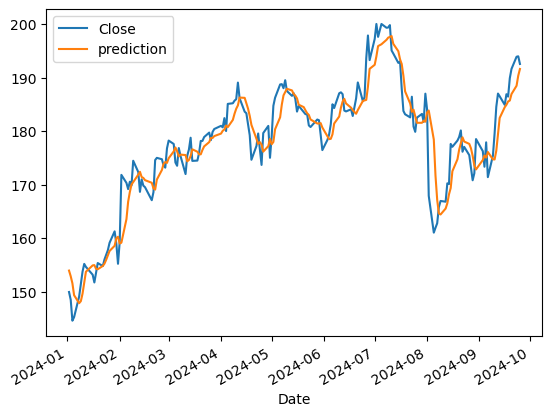

In [14]:
## função para LSTM


def LSTM_model(X_train, y_train, X_test, sc):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from keras.optimizers import SGD, Adam

    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=10, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, activation='tanh')) #Como é a última camada LSTM, a rede não precisa mais de uma sequência de saídas, apenas a saída final.
    my_LSTM_model.add(Dense(units=1))

    # Compiling
    my_LSTM_model.compile(optimizer=Adam(learning_rate=0.01),loss='mean_squared_error')
    # Fitting to the training set
    my_LSTM_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=0)

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

X_train, y_train, X_test, sc = ts_train_test_normalize(all_data,5,2)
my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)
LSTM_prediction[1:10]
actual_pred_plot(LSTM_prediction)


#Pedir, caso queiram, o vetor das previsões

#print(LSTM_prediction)

y_test = all_data.loc['2024':,'Close'][0:len(LSTM_prediction)].values
mae = mean_absolute_error(y_test, LSTM_prediction)
print("Mean Absolute Error (MAE):", mae)

mape = mean_absolute_percentage_error(y_test, LSTM_prediction)
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.3f}%")

c:\Users\diogo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
Mean Absolute Error (MAE): 2.859443296690245
Mean Absolute Percentage Error (MAPE): 1.628%


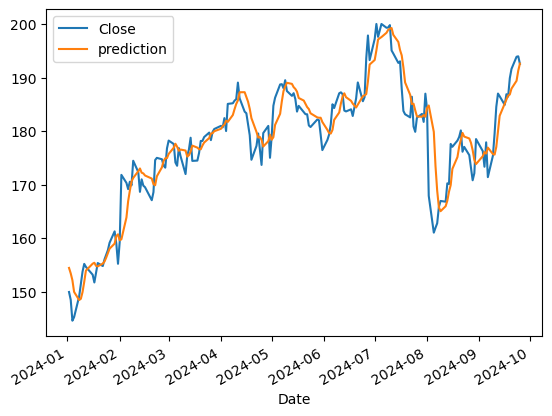

In [15]:
## função para LSTM


def LSTM_model(X_train, y_train, X_test, sc):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from keras.optimizers import SGD, Adam

    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, activation='tanh')) #Como é a última camada LSTM, a rede não precisa mais de uma sequência de saídas, apenas a saída final.
    my_LSTM_model.add(Dense(units=1))

    # Compiling
    my_LSTM_model.compile(optimizer=Adam(learning_rate=0.01),loss='mean_squared_error')
    # Fitting to the training set
    my_LSTM_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=0)

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

X_train, y_train, X_test, sc = ts_train_test_normalize(all_data,5,2)
my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)
LSTM_prediction[1:10]
actual_pred_plot(LSTM_prediction)


#Pedir, caso queiram, o vetor das previsões

#print(LSTM_prediction)

y_test = all_data.loc['2024':,'Close'][0:len(LSTM_prediction)].values
mae = mean_absolute_error(y_test, LSTM_prediction)
print("Mean Absolute Error (MAE):", mae)

mape = mean_absolute_percentage_error(y_test, LSTM_prediction)
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.3f}%")